<p style="font-size:14pt;text-align:center;">
Train YOLO network on pascal VOC.
</p>

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
import theano
from theano import tensor as T
import pickle as pk
import re
from copy import deepcopy
import sys
import simplejson

# image processing
from skimage.io import imread
from skimage.transform import resize
from skimage.color import rgb2hsv, hsv2rgb

import lasagne
from lasagne.layers import Pool2DLayer, Conv2DLayer, dropout, \
    DenseLayer, InputLayer, get_output, get_all_params
from lasagne import nonlinearities
from lasagne import layers
    
import bnr_ml.objectdetect.yolo as yolo
from bnr_ml.objectdetect import utils

import pdb

/Users/colingaudreau/anaconda2/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
Using gpu device 0: GeForce GTX 960 (CNMeM is enabled with initial size: 80.0% of memory, cuDNN not available)
/Library/Python/2.7/site-packages/theano/tensor/signal/downsample.py:6: UserWarning: downsample module has been moved to the theano.tensor.signal.pool module.
  "downsample module has been moved to the theano.tensor.signal.pool module.")


In [2]:
with open('/usr/local/python/bnr_ml/data/PascalVOC/annotations.json', 'r') as f:
    annotations = simplejson.load(f)

In [3]:
def get_label_counts(annotations):
    counts = np.zeros((4,))
    for a in annotations:
        for obj in a['annotations']:
            if obj['label'] == 'car':
                counts[0] += 1
            elif obj['label'] == 'bicycle':
                counts[1] += 1
            elif obj['label'] == 'bike':
                counts[2] += 1
            else:
                counts[3] += 1
    return counts

In [4]:
def fix_labels(annotations):
    for a in annotations:
        a['image'] = '/usr/local/python/bnr_ml/data/PascalVOC/' + a['image']
        new_objs = []
        for obj in a['annotations']:
            lab = obj['label'].lower()
            if 'car' in lab:
                lab = 'car'
            elif 'person' in lab:
                lab = 'person'
            elif 'bike' in lab:
                lab = 'bike'
            elif 'bicycle' in lab:
                lab = 'bicycle'
            else:
                lab = None
                
            if lab != None:
                obj['label'] = lab
                new_objs.append(obj)
        a['annotations'] = new_objs
    return annotations

In [5]:
annotations = np.asarray(fix_labels(annotations))

In [6]:
counts = get_label_counts(annotations)

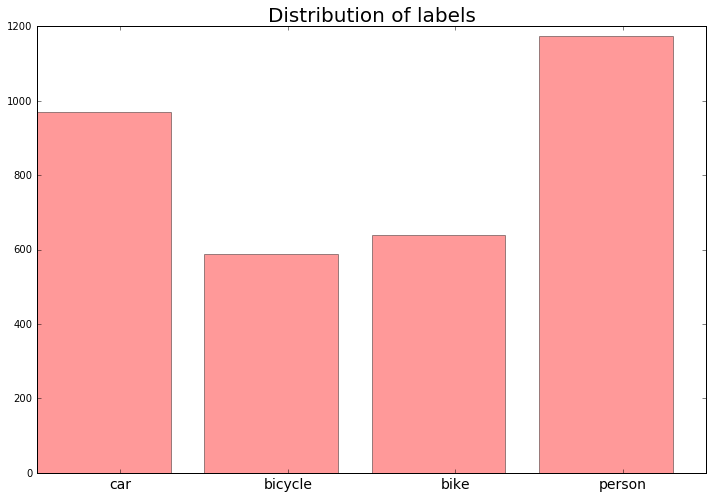

In [7]:
plt.figure(figsize=(12,8))
plt.title('Distribution of labels', fontsize=20)
plt.bar(np.arange(counts.size), counts, color='red', alpha=.4)
plt.xticks(np.arange(counts.size) + .5, ['car', 'bicycle', 'bike', 'person'], fontsize=14)
plt.show()

In [8]:
np.random.seed(1991)

<b>Split the annotations for training and testing, the reason I split by image and not individual object is so that when testing the performance, the network will never have seen any part of the test image.

In [9]:
with open('indices.pkl', 'rb') as f:
    indices = pk.load(f)
    train_idx = indices['train_index']
    test_idx = indices['test_index']

In [10]:
train_annotations = annotations[train_idx]
test_annotations = annotations[test_idx]

In [11]:
def generate_data_2(annotations, C, max_objs=15, size=(200,200), batch_size=100):
    def reformat_image(im, new_size):
        if im.shape.__len__() == 2:
            im = np.repeat(im.reshape(im.shape + (1,)), 3, axis=2)
        elif im.shape[2] > 3:
            im = im[:,:,:3]
        if im.shape[0] == 0 or im.shape[2] == 0:
            return None
        return resize(im, new_size).swapaxes(2,1).swapaxes(1,0)
    def transform_coord(coord, old_size, new_size):
        coord[[0,2]] = np.float_(coord[[0,2]]) / old_size[1]
        coord[[1,3]] = np.float_(coord[[1,3]]) / old_size[0]
        
        if coord[2] >= coord[0]:
            coord[2] -= coord[0]
        else:
            coord[2] = coord[0] - coord[2]
        if coord[3] >= coord[1]:
            coord[3] -= coord[1]
        else:
            coord[3] = coord[1] - coord[3]
        return coord
    def get_num_from_label(label):
        if label == 'car':
            return 0
        elif label == 'bicycle':
            return 1
        elif label == 'bike':
            return 2
        elif label == 'person':
            return 3
        elif label == 'noobj':
            return 4
        else:
            pass
        
#     annotations = np.asarray([[deepcopy(obj) for obj in objs] for objs in annotations]) # deep copy annotations

    fake_truth = np.concatenate((np.asarray([-10.,-10.,.01,.01]), np.zeros((C,))))
    
    np.random.shuffle(annotations)
    
    for i in range(0,annotations.shape[0], batch_size):
        Xbatch = np.zeros((batch_size,3) + size)
        ybatch = np.zeros((batch_size, (4 + C) * max_objs))
        
        for j in range(min(batch_size, annotations.shape[0] - i)):
            annotation = annotations[i+j]
            objs = annotation['annotations']
            im = imread(annotation['image'])
            old_size = np.float_(annotation['size'])
            
            Xbatch[j] = reformat_image(im, size)
            
            for k in range(max_objs):
                if k < objs.__len__():
                    obj = objs[k]
                    coord = np.asarray([
                            obj['x'],
                            obj['y'],
                            obj['w'],
                            obj['h']
                        ], dtype=theano.config.floatX)
                    coord = transform_coord(coord, old_size, size)
                    ybatch[j,k*(4 + C):k*(4 + C) + 4] = coord
                    ybatch[j,k*(4 + C)+4 + get_num_from_label(obj['label'])] += 1
                else:
                    ybatch[j,k*(4 + C):(k + 1)*(4 + C)] = fake_truth
            
        yield Xbatch[:j+1].astype(theano.config.floatX), ybatch[:j+1].astype(theano.config.floatX)

In [12]:
def generate_data_3(annotations, C, max_objs=15, size=(200,200), batch_size=100, augment=10):
    def reformat_image(im, new_size):
        if im.shape.__len__() == 2:
            im = np.repeat(im.reshape(im.shape + (1,)), 3, axis=2)
        elif im.shape[2] > 3:
            im = im[:,:,:3]
        if im.shape[0] == 0 or im.shape[2] == 0:
            return None
        return resize(im, new_size)
    def transform_coord(coord, old_size, new_size):
        coord[[0,2]] *= 1. / old_size[1]
        coord[[1,3]] *= 1. / old_size[0]
        
        if coord[2] >= coord[0]:
            coord[2] -= coord[0]
        else:
            coord[2] = coord[0] - coord[2]
        if coord[3] >= coord[1]:
            coord[3] -= coord[1]
        else:
            coord[3] = coord[1] - coord[3]
        return coord
    def get_num_from_label(label):
        if label == 'car':
            return 0
        elif label == 'bicycle':
            return 1
        elif label == 'bike':
            return 2
        elif label == 'person':
            return 3
        elif label == 'noobj':
            return 4
        else:
            pass
        
    annotations = np.asarray([[deepcopy(obj) for obj in objs] for objs in annotations]) # deep copy annotations

    fake_truth = np.concatenate((np.asarray([-10.,-10.,.01,.01]), np.zeros((C,))))
    
    np.random.shuffle(annotations)
    
    for num in range(augment):
        for i in range(0,annotations.size, batch_size):
            Xbatch = np.zeros((batch_size,3) + size)
            ybatch = np.zeros((batch_size, (4 + C) * max_objs))

            for j in range(min(batch_size, annotations.size - i)):
                objs = annotations[i+j][annotations]
                im = imread(annotations[i+j]['image'])
                old_size = im.shape
                
                old_box = Box(0.,0.,1.,1.)
                iterlap = .8
                new_width = iterlap + (1. - iterlap) * np.random.rand()
                new_height = iterlap +  (1. - iterlap) * np.random.rand()
                new_xi = (1. - new_width) * np.random.rand()
                new_yi = (1. - new_height) * np.random.rand()
                new_box = Box(
                    new_xi,
                    new_yi,
                    new_width + new_xi,
                    new_height + new_yi
                )
                im = new_box.subimage(im)

                im = reformat_image(im, size)
                
                im = rgb2hsv(im)
                im[:,:,[0,2]] *= (1 + .1 * np.random.rand(1,1,2))
                im = hsv2rgb(im)
                
                Xbatch[j] = im.swapaxes(2,1).swapaxes(1,0)

                for k in range(max_objs):
                    if k < objs.__len__():
                        obj = objs[k]
                        coord = np.asarray([
                                obj['x'],
                                obj['y'],
                                obj['w'],
                                obj['h']
                            ])
#                         coord = np.asarray(obj['p1'] + obj['p2']).astype(theano.config.floatX)
                        coord = transform_coord(coord, old_size, size)
                        
                        obj_box = Box(coord[0], coord[1], coord[0] + coord[2], coord[1] + coord[3])
                        
                        if new_box.iou(obj_box) > 0.5:
                            coord[0] -= new_box.xi
                            coord[1] -= new_box.yi
                            coord[[0,2]] /= (new_box.xf - new_box.xi)
                            coord[[1,3]] /= (new_box.yf - new_box.yi)
                            ybatch[j,k*(4 + C):k*(4 + C) + 4] = coord
                            ybatch[j,k*(4 + C)+4 + get_num_from_label(obj['label'])] += 1
                        else:
                            ybatch[j,k*(4 + C):(k + 1)*(4 + C)] = fake_truth

                    else:
                        ybatch[j,k*(4 + C):(k + 1)*(4 + C)] = fake_truth

            yield Xbatch[:j+1].astype(theano.config.floatX), ybatch[:j+1].astype(theano.config.floatX)

In [13]:
def generate_data(annotations, C, size=(200,200), batch_size=100):
    '''
    augment: how many times do you want the data to be replicated
    '''
    def get_objects(annotations):
        objs = []
        for im in annotations:
            objs.extend([deepcopy(obj) for obj in im])
        return np.asarray(objs)
    def get_num_from_label(label):
        if label == 'car':
            return 0
        elif label == 'bicycle':
            return 1
        elif label == 'bike':
            return 2
        elif label == 'person':
            return 3
        elif label == 'noobj':
            return 4
        else:
            pass
#             print('This shouldn\'t happen')
    def subsample_objs(objs, obj_idx, size):
        idx = obj_idx[np.random.random_integers(0,obj_idx.size-1, size=(size,))]
        copy_obj = []
        for obj in objs[idx]:
            copy_obj.append(deepcopy(obj))
        return np.asarray(copy_obj)
    def set_label_to_noobj(objs, obj_idx):
        N = np.int_(np.float_(obj_idx.size) / 5)
        idx = np.arange(obj_idx.size)
        np.random.shuffle(idx)
        for obj in objs[obj_idx[idx[:N]]]:
            obj['label']  = 'noobj'
        return objs
    
    # return flat list of objects
    objs = get_objects(annotations)
    
    # get number from label
    labels = np.asarray([get_num_from_label(obj['label']) for obj in objs])
    
    idx = np.arange(labels.size)
    idx_car = idx[labels==0]
    idx_bicycle = idx[labels==1]
    idx_bike = idx[labels==2]
    idx_person = idx[labels==3]
        
    max_labels = np.max([idx_car.size, idx_bicycle.size, idx_bike.size, idx_person.size])
    
    # get subsamples to get equal number of classes
    new_car = subsample_objs(objs, idx_car, max_labels - idx_car.size)
    new_bicycle = subsample_objs(objs, idx_bicycle, max_labels - idx_bicycle.size)
    new_bike = subsample_objs(objs, idx_bike, max_labels - idx_bike.size)
    new_person = subsample_objs(objs, idx_person, max_labels - idx_person.size)
    
    # add new samples
    objs = np.concatenate((objs, new_car, new_bicycle, new_bike, new_person))
    
    np.random.shuffle(objs)
    
    cnt = 0
    while cnt < objs.size:
        Xbatch = np.zeros((batch_size, 3) + size)
        ybatch = np.zeros((batch_size, 4 + C))
        batch_cnt = 0
        for j in range(batch_size):
            if cnt < objs.size:
                obj = objs[cnt]
                im = imread(obj['image'])
                im = im.astype(theano.config.floatX) / 255
                xscale, yscale = np.float_(size[1]) / im.shape[1], np.float_(size[0]) / im.shape[0]
#                 pdb.set_trace()
                coord = np.asarray(obj['p1'] + obj['p2']).astype(theano.config.floatX)
                coord[[0,2]] *= (xscale / 200)
                coord[[1,3]] *= (yscale / 200)
                if coord[2] >= coord[0]:
                    coord[2] -= coord[0]
                else:
                    coord[2] = coord[0] - coord[2]
                if coord[3] >= coord[1]:
                    coord[3] -= coord[1]
                else:
                    coord[3] = coord[1] - coord[3]
                    
                if coord[2] < 0 or coord[3] < 0:
                    print image
                    
                if im.shape.__len__() == 2:
                    im = im.reshape(im.shape + (1,))
                    im = np.concatenate((im, im, im), axis=2)
                elif im.shape[2] == 4:
                    im = im[:,:,:3]
                if not (im.shape[0] == 0 or im.shape[1] == 0):
                    im = resize(im, size).swapaxes(2,1).swapaxes(1,0)
                    Xbatch[batch_cnt] = im
                    ybatch[batch_cnt, :4] =  coord
                    ybatch[batch_cnt, 4 + get_num_from_label(obj['label'])] += 1
                    batch_cnt += 1
            cnt += 1
        if batch_cnt < batch_size - 1:
            Xbatch, ybatch = Xbatch[:batch_cnt], ybatch[:batch_cnt]
        yield Xbatch.astype(theano.config.floatX), ybatch.astype(theano.config.floatX)

<b>Now we define the net for recognition.</b>

In [181]:
S = (5,5)
B = 2
C = 4

In [186]:
num_epochs = 1000
batch_size = 10
input_shape = (224,224)

In [226]:
test_net = True
if test_net:
    Xtest, ytest = [t for t in generate_data_2(train_annotations[[600]], C, batch_size=batch_size, size=input_shape)][0]
    Xtest, ytest = theano.shared(Xtest), theano.shared(ytest)
    input_var = Xtest
else:
    input_var=None

In [227]:
import lasagne.nonlinearities as nonlinearities

In [228]:
net = {}
net['input'] = InputLayer((None, 3) + input_shape, input_var=input_var)
net['conv1_1'] = Conv2DLayer(net['input'], 64, 3, pad=1, nonlinearity=nonlinearities.leaky_rectify)
net['conv1_2'] = Conv2DLayer(net['conv1_1'], 64, 3, pad=1, nonlinearity=nonlinearities.leaky_rectify)
net['pool1'] = Pool2DLayer(net['conv1_2'], 2)
net['conv2_1'] = Conv2DLayer( net['pool1'], 128, 3, pad=1, nonlinearity=nonlinearities.leaky_rectify)
net['conv2_2'] = Conv2DLayer(net['conv2_1'], 128, 3, pad=1, nonlinearity=nonlinearities.leaky_rectify)
net['pool2'] = Pool2DLayer(net['conv2_2'], 2)
net['conv3_1'] = Conv2DLayer(net['pool2'], 256, 3, pad=1, nonlinearity=nonlinearities.leaky_rectify)
net['conv3_2'] = Conv2DLayer(net['conv3_1'], 256, 3, pad=1, nonlinearity=nonlinearities.leaky_rectify)
net['conv3_3'] = Conv2DLayer(net['conv3_2'], 256, 3, pad=1, nonlinearity=nonlinearities.leaky_rectify)
net['pool3'] = Pool2DLayer(net['conv3_3'], 2)
net['conv4_1'] = Conv2DLayer(net['pool3'], 512, 3, pad=1, nonlinearity=nonlinearities.leaky_rectify)
net['conv4_2'] = Conv2DLayer(net['conv4_1'], 512, 3, pad=1, nonlinearity=nonlinearities.leaky_rectify)
net['conv4_3'] = Conv2DLayer(net['conv4_2'], 512, 3, pad=1, nonlinearity=nonlinearities.leaky_rectify)
net['pool4'] = Pool2DLayer(net['conv4_3'], 2)
net['conv5_1'] = Conv2DLayer(net['pool4'], 512, 3, pad=1, nonlinearity=nonlinearities.leaky_rectify)
net['conv5_2'] = Conv2DLayer(net['conv5_1'], 512, 3, pad=1, nonlinearity=nonlinearities.leaky_rectify)
net['conv5_3'] = Conv2DLayer(net['conv5_2'], 512, 3, pad=1, nonlinearity=nonlinearities.leaky_rectify)
net['pool5'] = Pool2DLayer(net['conv5_3'], 2)
net['fc6'] = DenseLayer(net['pool5'], num_units=2048, nonlinearity=None)
net['fc6_dropout'] = dropout(net['fc6'], p=0)
net['fc7'] = DenseLayer(net['fc6_dropout'], num_units=2048, nonlinearity=None)
net['fc7_dropout'] = dropout(net['fc7'], p=0)
# net['fc8'] = DenseLayer(net['fc7_dropout'], num_units=1000, nonlinearity=None)
# net['prob'] = NonlinearityLayer(net['fc8'], nonlinearities.softmax)

<b>Load pre-trained weights</b>

In [204]:
load_pretrained = True
if load_pretrained:
    with open('/usr/local/python/bnr_ml/data/pretrained/vgg16.pkl', 'rb') as f:
        weights = pk.load(f)['param values']
        lasagne.layers.set_all_param_values(net['conv5_3'], weights[:-6])

<b>Add extra layers to network for detection</b>

In [229]:
net['fc6'] = DenseLayer(net['pool5'], 2048, nonlinearity=None)
net['output'] = DenseLayer(dropout(net['fc6'], p=0), (B * (C + 1) + 4) * (S[0] * S[1]), nonlinearity=None)
# net['output'] = DenseLayer(dropout(net['dense1'], p=.0), (B * 5 + C) * S[0]*S[1])

In [230]:
load_weights = True
if load_weights:
    with open('tmp.pkl', 'rb') as f:
        weights = pk.load(f)
        lasagne.layers.set_all_param_values(net['output'], weights)

<b>Train the network

In [231]:
import bnr_ml.utils.nonlinearities as nonlinearities

In [232]:
reload(nonlinearities)
reload(yolo)

<module 'bnr_ml.objectdetect.yolo' from '/usr/local/python/bnr_ml/objectdetect/yolo.pyc'>

In [233]:
yl = yolo.YoloObjectDetector(net, (None, 3) + input_shape, C, S, B) 

In [223]:
gen_fn = lambda ann, shape, batch_size: generate_data_2(ann, C, size=shape, batch_size=batch_size)

In [234]:
cost = yl._get_cost(yl.output, ytest, S, B, C)

> /usr/local/python/bnr_ml/objectdetect/yolo.py(255)_get_cost()
-> cost /= T.maximum(1., truth.shape[0])
(Pdb) cost.eval()
array(6.828886985778809, dtype=float32)
(Pdb) obj_in_cell_and_resp[0,0].eval()
array([[[0, 1, 1, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0]],

       [[0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0]]], dtype=int8)
(Pdb) obj_in_cell_and_resp[0,1].eval()
array([[[0, 0, 0, 0, 1],
        [0, 0, 0, 1, 1],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0]],

       [[0, 0, 0, 1, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0]]], dtype=int8)
(Pdb) obj_in_cell_and_resp[0,2].eval()
array([[[0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0]],

       [[0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0,

BdbQuit: 

In [212]:
train_loss, test_loss = yl.train(
    gen_fn,
    train_annotations[[600]],
    test_annotations[:1],
    lr=1e-5,
    epochs=4000
)

Getting cost...
Creating cost variable took 0.7502 seconds
Compiling...


  0%|          | 0/4000 [00:00<?, ?it/s]

Compiling functions took 165.6465 seconds
Beginning training...
89.9962768555


  0%|          | 1/4000 [00:03<3:49:34,  3.44s/it]

Epoch 0
------
Train Loss: 89.9963, Test Loss: 388.8329
234.042419434


  0%|          | 2/4000 [00:06<3:48:14,  3.43s/it]

Epoch 1
------
Train Loss: 234.0424, Test Loss: 271.2459
29.5251331329


  0%|          | 3/4000 [00:10<3:47:26,  3.41s/it]

Epoch 2
------
Train Loss: 29.5251, Test Loss: 262.7274
14.3736896515


  0%|          | 4/4000 [00:13<3:46:52,  3.41s/it]

Epoch 3
------
Train Loss: 14.3737, Test Loss: 259.2652
10.8404922485


  0%|          | 5/4000 [00:16<3:46:35,  3.40s/it]

Epoch 4
------
Train Loss: 10.8405, Test Loss: 260.9653
13.8383483887


  0%|          | 6/4000 [00:20<3:46:12,  3.40s/it]

Epoch 5
------
Train Loss: 13.8383, Test Loss: 256.4578
12.9705543518


  0%|          | 7/4000 [00:23<3:46:05,  3.40s/it]

Epoch 6
------
Train Loss: 12.9706, Test Loss: 261.9932
12.9037322998


  0%|          | 8/4000 [00:27<3:45:51,  3.39s/it]

Epoch 7
------
Train Loss: 12.9037, Test Loss: 258.7592
10.5718927383


  0%|          | 9/4000 [00:30<3:45:40,  3.39s/it]

Epoch 8
------
Train Loss: 10.5719, Test Loss: 258.1229
16.2630805969


  0%|          | 10/4000 [00:33<3:45:33,  3.39s/it]

Epoch 9
------
Train Loss: 16.2631, Test Loss: 253.0119
9.73883056641


  0%|          | 11/4000 [00:37<3:45:34,  3.39s/it]

Epoch 10
------
Train Loss: 9.7388, Test Loss: 260.6327
13.0348739624


  0%|          | 12/4000 [00:40<3:45:35,  3.39s/it]

Epoch 11
------
Train Loss: 13.0349, Test Loss: 251.1095
8.34372329712


  0%|          | 13/4000 [00:44<3:45:25,  3.39s/it]

Epoch 12
------
Train Loss: 8.3437, Test Loss: 254.8656
7.80588340759


  0%|          | 14/4000 [00:47<3:45:23,  3.39s/it]

Epoch 13
------
Train Loss: 7.8059, Test Loss: 254.3803
8.31028747559


  0%|          | 15/4000 [00:50<3:45:21,  3.39s/it]

Epoch 14
------
Train Loss: 8.3103, Test Loss: 251.6148
12.6352310181


  0%|          | 16/4000 [00:54<3:45:13,  3.39s/it]

Epoch 15
------
Train Loss: 12.6352, Test Loss: 253.5243
8.90883159637


  0%|          | 17/4000 [00:57<3:45:12,  3.39s/it]

Epoch 16
------
Train Loss: 8.9088, Test Loss: 270.8531
7.8973531723


  0%|          | 18/4000 [01:01<3:45:13,  3.39s/it]

Epoch 17
------
Train Loss: 7.8974, Test Loss: 253.5076
7.58640384674


  0%|          | 19/4000 [01:04<3:45:05,  3.39s/it]

Epoch 18
------
Train Loss: 7.5864, Test Loss: 268.3701
8.29861068726


  0%|          | 20/4000 [01:07<3:44:54,  3.39s/it]

Epoch 19
------
Train Loss: 8.2986, Test Loss: 251.0682
10.2021951675


  1%|          | 21/4000 [01:11<3:44:49,  3.39s/it]

Epoch 20
------
Train Loss: 10.2022, Test Loss: 257.2019
10.6070127487


  1%|          | 22/4000 [01:14<3:44:51,  3.39s/it]

Epoch 21
------
Train Loss: 10.6070, Test Loss: 246.2082
9.07131576538


  1%|          | 23/4000 [01:18<3:44:51,  3.39s/it]

Epoch 22
------
Train Loss: 9.0713, Test Loss: 241.8207
11.9644927979


  1%|          | 24/4000 [01:21<3:44:51,  3.39s/it]

Epoch 23
------
Train Loss: 11.9645, Test Loss: 245.5124
7.92148685455


  1%|          | 25/4000 [01:24<3:44:44,  3.39s/it]

Epoch 24
------
Train Loss: 7.9215, Test Loss: 247.1259
7.48273897171


  1%|          | 26/4000 [01:28<3:44:46,  3.39s/it]

Epoch 25
------
Train Loss: 7.4827, Test Loss: 246.4067
7.38208150864


  1%|          | 27/4000 [01:31<3:44:45,  3.39s/it]

Epoch 26
------
Train Loss: 7.3821, Test Loss: 243.2529
7.64601421356


  1%|          | 28/4000 [01:35<3:44:42,  3.39s/it]

Epoch 27
------
Train Loss: 7.6460, Test Loss: 243.4407
6.43660163879


  1%|          | 29/4000 [01:38<3:44:38,  3.39s/it]

Epoch 28
------
Train Loss: 6.4366, Test Loss: 246.4357
6.38312149048


  1%|          | 30/4000 [01:41<3:44:31,  3.39s/it]

Epoch 29
------
Train Loss: 6.3831, Test Loss: 238.5154
7.28071641922


  1%|          | 31/4000 [01:45<3:44:23,  3.39s/it]

Epoch 30
------
Train Loss: 7.2807, Test Loss: 244.5684
6.73841714859


  1%|          | 32/4000 [01:48<3:44:14,  3.39s/it]

Epoch 31
------
Train Loss: 6.7384, Test Loss: 279.5674
6.36346912384


  1%|          | 33/4000 [01:51<3:44:07,  3.39s/it]

Epoch 32
------
Train Loss: 6.3635, Test Loss: 265.1076
7.92405748367


  1%|          | 34/4000 [01:55<3:44:12,  3.39s/it]

Epoch 33
------
Train Loss: 7.9241, Test Loss: 269.1025
7.76064109802


  1%|          | 35/4000 [01:58<3:44:08,  3.39s/it]

Epoch 34
------
Train Loss: 7.7606, Test Loss: 253.7387
6.84630298615


  1%|          | 36/4000 [02:02<3:44:00,  3.39s/it]

Epoch 35
------
Train Loss: 6.8463, Test Loss: 272.9112
9.01616191864


  1%|          | 37/4000 [02:05<3:44:01,  3.39s/it]

Epoch 36
------
Train Loss: 9.0162, Test Loss: 263.5920
6.3703289032


  1%|          | 38/4000 [02:08<3:44:01,  3.39s/it]

Epoch 37
------
Train Loss: 6.3703, Test Loss: 262.2647
6.40456008911


  1%|          | 39/4000 [02:12<3:43:59,  3.39s/it]

Epoch 38
------
Train Loss: 6.4046, Test Loss: 263.7000
6.68786668777


  1%|          | 40/4000 [02:15<3:43:57,  3.39s/it]

Epoch 39
------
Train Loss: 6.6879, Test Loss: 262.2108
7.70185565948


  1%|          | 41/4000 [02:19<3:43:46,  3.39s/it]

Epoch 40
------
Train Loss: 7.7019, Test Loss: 254.5259
6.23783111572


  1%|          | 42/4000 [02:22<3:43:45,  3.39s/it]

Epoch 41
------
Train Loss: 6.2378, Test Loss: 241.5477
7.58229541779


  1%|          | 43/4000 [02:25<3:43:47,  3.39s/it]

Epoch 42
------
Train Loss: 7.5823, Test Loss: 251.0914
5.2267036438


  1%|          | 44/4000 [02:29<3:43:37,  3.39s/it]

Epoch 43
------
Train Loss: 5.2267, Test Loss: 256.3172
5.40580558777


  1%|          | 45/4000 [02:32<3:43:38,  3.39s/it]

Epoch 44
------
Train Loss: 5.4058, Test Loss: 252.9626
3.94920516014


  1%|          | 46/4000 [02:36<3:43:39,  3.39s/it]

Epoch 45
------
Train Loss: 3.9492, Test Loss: 249.7204
4.49221229553


  1%|          | 47/4000 [02:39<3:43:27,  3.39s/it]

Epoch 46
------
Train Loss: 4.4922, Test Loss: 260.5374
6.85945749283


  1%|          | 48/4000 [02:42<3:43:27,  3.39s/it]

Epoch 47
------
Train Loss: 6.8595, Test Loss: 245.7871
10.6906833649


  1%|          | 49/4000 [02:46<3:43:27,  3.39s/it]

Epoch 48
------
Train Loss: 10.6907, Test Loss: 250.0291
8.03343200684


  1%|▏         | 50/4000 [02:49<3:43:20,  3.39s/it]

Epoch 49
------
Train Loss: 8.0334, Test Loss: 250.9546
5.24765920639


  1%|▏         | 51/4000 [02:53<3:43:22,  3.39s/it]

Epoch 50
------
Train Loss: 5.2477, Test Loss: 241.9741
5.59359741211


  1%|▏         | 52/4000 [02:56<3:43:21,  3.39s/it]

Epoch 51
------
Train Loss: 5.5936, Test Loss: 251.2694
5.18792915344


  1%|▏         | 53/4000 [02:59<3:43:09,  3.39s/it]

Epoch 52
------
Train Loss: 5.1879, Test Loss: 249.5119
3.40019655228


  1%|▏         | 54/4000 [03:03<3:43:11,  3.39s/it]

Epoch 53
------
Train Loss: 3.4002, Test Loss: 251.8235
4.5720281601


  1%|▏         | 55/4000 [03:06<3:43:11,  3.39s/it]

Epoch 54
------
Train Loss: 4.5720, Test Loss: 239.8753
11.1144618988


  1%|▏         | 56/4000 [03:10<3:43:01,  3.39s/it]

Epoch 55
------
Train Loss: 11.1145, Test Loss: 249.1613
3.99731445312


  1%|▏         | 57/4000 [03:13<3:42:52,  3.39s/it]

Epoch 56
------
Train Loss: 3.9973, Test Loss: 244.6610
3.83466672897


  1%|▏         | 58/4000 [03:16<3:42:50,  3.39s/it]

Epoch 57
------
Train Loss: 3.8347, Test Loss: 248.0818
4.21503639221


  1%|▏         | 59/4000 [03:20<3:42:44,  3.39s/it]

Epoch 58
------
Train Loss: 4.2150, Test Loss: 247.7197
4.40696573257


  2%|▏         | 60/4000 [03:23<3:42:34,  3.39s/it]

Epoch 59
------
Train Loss: 4.4070, Test Loss: 247.4231
4.30891752243


  2%|▏         | 61/4000 [03:26<3:42:32,  3.39s/it]

Epoch 60
------
Train Loss: 4.3089, Test Loss: 251.0174
4.72106838226


  2%|▏         | 62/4000 [03:30<3:42:32,  3.39s/it]

Epoch 61
------
Train Loss: 4.7211, Test Loss: 245.7373
4.18695354462


  2%|▏         | 63/4000 [03:33<3:42:36,  3.39s/it]

Epoch 62
------
Train Loss: 4.1870, Test Loss: 249.4709
5.51467227936


  2%|▏         | 64/4000 [03:37<3:42:28,  3.39s/it]

Epoch 63
------
Train Loss: 5.5147, Test Loss: 244.4713
6.14282751083


  2%|▏         | 65/4000 [03:40<3:42:29,  3.39s/it]

Epoch 64
------
Train Loss: 6.1428, Test Loss: 244.6650
4.16630506516


  2%|▏         | 66/4000 [03:43<3:42:30,  3.39s/it]

Epoch 65
------
Train Loss: 4.1663, Test Loss: 245.3319
3.31735444069


  2%|▏         | 67/4000 [03:47<3:42:16,  3.39s/it]

Epoch 66
------
Train Loss: 3.3174, Test Loss: 248.3030
3.74732732773


  2%|▏         | 68/4000 [03:50<3:42:08,  3.39s/it]

Epoch 67
------
Train Loss: 3.7473, Test Loss: 241.3107
5.06152105331


  2%|▏         | 69/4000 [03:54<3:42:03,  3.39s/it]

Epoch 68
------
Train Loss: 5.0615, Test Loss: 249.2048
4.92022371292


  2%|▏         | 70/4000 [03:57<3:42:04,  3.39s/it]

Epoch 69
------
Train Loss: 4.9202, Test Loss: 248.3478
5.40234947205


  2%|▏         | 71/4000 [04:00<3:41:56,  3.39s/it]

Epoch 70
------
Train Loss: 5.4023, Test Loss: 226.5981
4.46895456314


  2%|▏         | 72/4000 [04:04<3:41:51,  3.39s/it]

Epoch 71
------
Train Loss: 4.4690, Test Loss: 239.2465
5.13065052032


  2%|▏         | 73/4000 [04:07<3:41:55,  3.39s/it]

Epoch 72
------
Train Loss: 5.1307, Test Loss: 233.7051
8.22292613983


  2%|▏         | 74/4000 [04:11<3:41:55,  3.39s/it]

Epoch 73
------
Train Loss: 8.2229, Test Loss: 233.0817
3.23943519592


  2%|▏         | 75/4000 [04:14<3:41:47,  3.39s/it]

Epoch 74
------
Train Loss: 3.2394, Test Loss: 232.0603
4.50932264328


  2%|▏         | 76/4000 [04:17<3:41:38,  3.39s/it]

Epoch 75
------
Train Loss: 4.5093, Test Loss: 242.8823
3.15046525002


  2%|▏         | 77/4000 [04:21<3:41:33,  3.39s/it]

Epoch 76
------
Train Loss: 3.1505, Test Loss: 238.9627
3.57137131691


  2%|▏         | 78/4000 [04:24<3:41:37,  3.39s/it]

Epoch 77
------
Train Loss: 3.5714, Test Loss: 242.2268
4.5509557724


  2%|▏         | 79/4000 [04:27<3:41:40,  3.39s/it]

Epoch 78
------
Train Loss: 4.5510, Test Loss: 229.6592
4.35165929794


  2%|▏         | 80/4000 [04:31<3:41:41,  3.39s/it]

Epoch 79
------
Train Loss: 4.3517, Test Loss: 243.4014
3.93850278854


  2%|▏         | 81/4000 [04:34<3:41:40,  3.39s/it]

Epoch 80
------
Train Loss: 3.9385, Test Loss: 227.8012
3.25925135612


  2%|▏         | 82/4000 [04:38<3:41:39,  3.39s/it]

Epoch 81
------
Train Loss: 3.2593, Test Loss: 239.8714
2.69980192184


  2%|▏         | 83/4000 [04:41<3:41:30,  3.39s/it]

Epoch 82
------
Train Loss: 2.6998, Test Loss: 242.2705
4.50675964355


  2%|▏         | 84/4000 [04:44<3:41:27,  3.39s/it]

Epoch 83
------
Train Loss: 4.5068, Test Loss: 237.9395
7.01947689056


  2%|▏         | 85/4000 [04:48<3:41:22,  3.39s/it]

Epoch 84
------
Train Loss: 7.0195, Test Loss: 216.4248
5.6079659462


  2%|▏         | 86/4000 [04:51<3:41:16,  3.39s/it]

Epoch 85
------
Train Loss: 5.6080, Test Loss: 217.9368
3.46041846275


  2%|▏         | 87/4000 [04:55<3:41:15,  3.39s/it]

Epoch 86
------
Train Loss: 3.4604, Test Loss: 218.3046
5.18940258026


  2%|▏         | 88/4000 [04:58<3:41:15,  3.39s/it]

Epoch 87
------
Train Loss: 5.1894, Test Loss: 216.3458
3.09071922302


  2%|▏         | 89/4000 [05:01<3:41:06,  3.39s/it]

Epoch 88
------
Train Loss: 3.0907, Test Loss: 227.2064
2.73151135445


  2%|▏         | 90/4000 [05:05<3:40:56,  3.39s/it]

Epoch 89
------
Train Loss: 2.7315, Test Loss: 213.7443
2.33831834793


  2%|▏         | 91/4000 [05:08<3:41:07,  3.39s/it]

Epoch 90
------
Train Loss: 2.3383, Test Loss: 233.9711
8.39233016968


  2%|▏         | 92/4000 [05:12<3:40:53,  3.39s/it]

Epoch 91
------
Train Loss: 8.3923, Test Loss: 219.7237
3.91564369202


  2%|▏         | 93/4000 [05:15<3:40:54,  3.39s/it]

Epoch 92
------
Train Loss: 3.9156, Test Loss: 220.2858
6.74210071564


  2%|▏         | 94/4000 [05:18<3:40:57,  3.39s/it]

Epoch 93
------
Train Loss: 6.7421, Test Loss: 225.4013
6.56264686584


  2%|▏         | 95/4000 [05:22<3:40:51,  3.39s/it]

Epoch 94
------
Train Loss: 6.5626, Test Loss: 222.0687
3.3501663208


  2%|▏         | 96/4000 [05:25<3:40:44,  3.39s/it]

Epoch 95
------
Train Loss: 3.3502, Test Loss: 222.0941
2.83610582352


  2%|▏         | 97/4000 [05:29<3:40:35,  3.39s/it]

Epoch 96
------
Train Loss: 2.8361, Test Loss: 225.5633
2.80717086792


  2%|▏         | 98/4000 [05:32<3:40:36,  3.39s/it]

Epoch 97
------
Train Loss: 2.8072, Test Loss: 216.3419
4.61772441864


  2%|▏         | 99/4000 [05:35<3:40:34,  3.39s/it]

Epoch 98
------
Train Loss: 4.6177, Test Loss: 222.3562
4.46983861923


  2%|▎         | 100/4000 [05:39<3:40:28,  3.39s/it]

Epoch 99
------
Train Loss: 4.4698, Test Loss: 220.7275
4.28714084625


  3%|▎         | 101/4000 [05:42<3:40:22,  3.39s/it]

Epoch 100
------
Train Loss: 4.2871, Test Loss: 224.3265
2.37291622162


  3%|▎         | 102/4000 [05:46<3:40:14,  3.39s/it]

Epoch 101
------
Train Loss: 2.3729, Test Loss: 220.7497
3.19657707214


  3%|▎         | 103/4000 [05:49<3:40:12,  3.39s/it]

Epoch 102
------
Train Loss: 3.1966, Test Loss: 221.3094
3.29179763794


In [214]:
with open('tmp.pkl', 'wb') as f:
    weights = lasagne.layers.get_all_param_values(net['output'])
    pk.dump(weights, f)

In [251]:
concat_loss = False
if concat_loss:
    train_loss_total = np.concatenate((train_loss_total, train_loss))
    test_loss_total = np.concatenate((test_loss_total, test_loss))
else:
    train_loss_total, test_loss_total = train_loss, test_loss

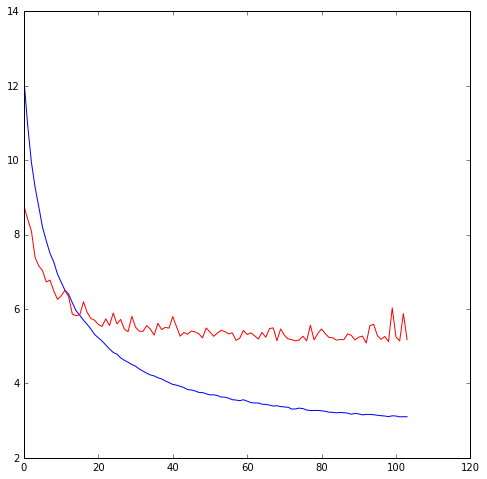

In [252]:
plt.figure(figsize=(8,8))
idx = train_loss_total != 0
plt.plot(train_loss_total[idx], 'b')
plt.plot(test_loss_total[idx], 'r')

In [91]:
def get_label_from_num(num):
    if num == 0:
        return 'car'
    elif num == 1:
        return 'bicycle'
    elif num == 2:
        return 'bike'
    elif num == 3:
        return 'person'

In [82]:
swap = lambda im: im.swapaxes(0,1).swapaxes(1,2)

In [171]:
gen = generate_data_2(train_annotations[[600]], C, max_objs=5, size=input_shape)

In [172]:
testdat = [t for t in gen]

In [173]:
Xtest, ytest = testdat[0]

In [174]:
print np.round(100*ytest)/100

[[  0.22         0.06         0.19         0.02         0.           0.
    0.           1.           0.67000002   0.01         0.58999997
    0.36000001   0.           0.           0.           1.           0.80000001
    0.           0.69         0.38         0.           0.           0.
    1.         -10.         -10.           0.01         0.01         0.
    0.           0.           0.         -10.         -10.           0.01
    0.01         0.           0.           0.           0.        ]]


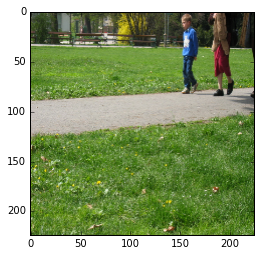

In [180]:
plt.imshow(swap(Xtest[0]))

In [146]:
out_fn = theano.function([yl.input], yl.output_test)

In [147]:
Xtest_out = out_fn(Xtest[:])

In [148]:
np.round(100 * Xtest_out[0,:,3,2]) / 100

array([-0.75      , -0.13      ,  0.18000001,  1.13999999,  0.03      ,
        1.63      , -0.67000002,  1.23000002,  0.77999997,  0.05      ,
        0.16      ,  0.36000001,  0.33000001,  0.15000001], dtype=float32)

In [149]:
N = int(np.random.rand() * Xtest_out.shape[0])
print N

0


In [150]:
coords = yolo.YoloObjectDetector.nms(Xtest_out[N], S, B, C, thresh=.2, overlap=.05)
print coords.shape

(3, 6)


/usr/local/python/bnr_ml/objectdetect/utils.py:136: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 2 but corresponding boolean dimension is 1
  idx = idx[o<thresh]


In [153]:
coords

array([[ 0.93441576,  0.89068109,  0.31882238,  0.07036921,  0.64303583,
         2.        ],
       [ 0.66711962,  0.01253266,  0.59470856,  0.3645238 ,  0.36619809,
         2.        ],
       [ 0.66774493,  0.00749772,  0.59494829,  0.36273786,  0.68746239,
         3.        ]])

In [151]:
im = utils.draw_coord(swap(Xtest[N]), coords, get_label_from_num)

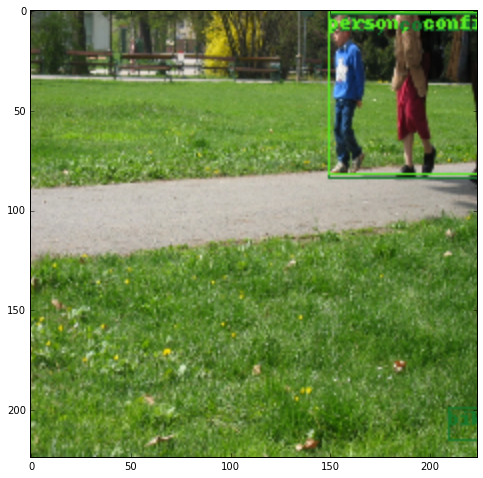

In [152]:
plt.figure(figsize=(8,8))
plt.imshow(im)

In [292]:
pred = np.copy(Xtest_out[N])
score = pred[[4,9]] * pred[-C:].max(keepdims=True)
score = score.flatten()
args = score.argsort()[::-1][:10]
preds = []
for i in range(args.size):
    idx = np.unravel_index(args[i], pred[[4,9]].shape)
    crd = pred[5*idx[0]:5*idx[0] + 4,idx[1], idx[2]]
    tmp = crd[[2,3]]
    tmp[tmp<1] = 0.5*tmp[tmp<1]**2
    tmp[tmp>=1] = np.abs(tmp[tmp>=1]) - 0.5
    crd[[2,3]] = tmp
    crd = crd.tolist()
    crd[0], crd[1] = crd[0] + np.float_(idx[2]) /S[1], crd[1] + np.float_(idx[1]) / S[0]
    crd.append(score[args[i]])
    preds.append(crd)
preds = np.asarray(preds)

In [ ]:
nms(preds, .3)

In [ ]:
plt.imshow(draw_coord(swap(Xtest[N]), nms(preds, .3)[0], None))

In [ ]:
tmp = np.arange()

In [ ]:
swap = lambda x: x.swapaxes(0,1).swapaxes(1,2)

In [ ]:
N = int(Xtest.shape[0] * np.random.rand())
print N
a, b = draw_best(swap(Xtest[N]), Xtest_out[N], num = 5, thresh=.2)

In [ ]:
plt.figure(figsize=(6,6))
plt.imshow(a)
print b
# print '%s with class score: %.3f, objectness: %.3f' % (get_label_from_num(c.argmax()), c.max(), b)
# print c
# print d

In [ ]:
im = swap(Xtest[int(np.random.rand()*Xtest.shape[0])])

In [ ]:
im2 = rgb2hsv(im)

In [ ]:
im2[:,:,1:] *= (1. + .3 * np.random.rand(1,1,2))

In [ ]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.imshow(im)
plt.subplot(1,2,2)
plt.imshow(hsv2rgb(im2))

In [ ]:
im3 = hsv2rgb(im2)